In [1]:
# General imports
import os
import random
import math
import itertools
import pandas as pd
from tqdm import tqdm
import numpy as np
from datasets import load_metric

# pytorch imports
import torch

# Transformer tokenizer imports
from transformers import BertTokenizerFast

# Transformers data collator
from transformers.data.data_collator import DataCollatorWithPadding

# Transformers Bert model
from transformers import AutoModelForSequenceClassification, BertForPreTraining, Trainer, TrainingArguments, EarlyStoppingCallback, BertConfig

MAX_SEQ_LEN = 512

2022-05-13 12:35:24.992299: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.


In [2]:
# GPU settings
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NVIDIA_VISIBLE_DEVICES"] = "0"

In [3]:
def load_tokenizer(tokenizer_path):
    # load tokenizer from dict
    tokenizer =  BertTokenizerFast.from_pretrained(tokenizer_path)
    return tokenizer

In [4]:
class AsmToSymbolicDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, tokenizer, task):
        
        self.data_store = []
        df = pd.read_csv(dataset_path, sep="\t").fillna('')
        # df["instr_len"] = df["ot_instructions"].apply(lambda x: len(x.split("NEXT_I")))
        # df = df[df["instr_len"]>=10]
        
        if task == "compiler":
            self.labels_to_idx = {'clang-3.8': 0, 'clang-6.0':1, 'clang-9':2, 
                                  'gcc-5':3, 'gcc-7':4, 'gcc-9':5, 'icc-21':6}
            self.samples = df[["ot_instructions", "compiler"]]
            
        elif task == "optimization":
            self.labels_to_idx =  {'O0': 0, 'O1': 1, 'O2': 2, 'O3': 3}
            self.samples = df[["ot_instructions", "optimization"]]
                  
        else:
            raise Exception(f"{task} is not a valid task")
        
        self.tokenizer = tokenizer
            
        self.__init_structures()
         
    def __init_structures(self):
        
        for x,y in tqdm(self.samples.values):
            x = x.replace("NEXT_I ", "")
            example = self.tokenizer(text=x, truncation=True, max_length=MAX_SEQ_LEN)
            example["label"] = self.labels_to_idx[y]
            self.data_store.append(example)
            
        random.shuffle(self.data_store)
                
    def __len__(self) -> int:
        return len(self.data_store)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_store[idx]
    
    def save_to_file(self,save_file):
        torch.save(self.data_store, save_file)

# **Training**

In [5]:
from_scratch = False

#if from_scratch:
LEARNING_RATE = 0.0001
#else:
#    LEARNING_RATE = 0.00001

NUM_TRAIN_EPOCHS = 20
PER_DEVICE_TRAIN_BATCH_SIZE = 32
PER_DEVICE_EVAL_BATCH_SIZE = 32
DATA_LOADER_NUM_WORKERS = 4
PATIENCE = 3

#models
BXSMAL="bert_xsmall"
BSMAL="bert_small"
BNORM="bert_normal"
BLARG="bert_larg"

MODEL=BNORM 

# Parameter settings -- of default model BSMAL
MAX_SEQ_LEN = 512
MAX_POSITION_EMBEDDINGS = 514
HIDDEN_SIZE = 512
INTERMEDIATE_SIZE = 2048
NUM_ATTENTION_HEADS = 8
NUM_HIDDEN_LAYERS = 12
TYPE_VOCAB_SIZE = 2

if MODEL == BXSMAL:
    MAX_SEQ_LEN = 512
    MAX_POSITION_EMBEDDINGS = 514
    HIDDEN_SIZE = 128
    INTERMEDIATE_SIZE = 1024
    NUM_ATTENTION_HEADS = 8
    NUM_HIDDEN_LAYERS = 12
    TYPE_VOCAB_SIZE = 2

if MODEL == BSMAL:
    MAX_SEQ_LEN = 512
    MAX_POSITION_EMBEDDINGS = 514
    HIDDEN_SIZE = 512
    INTERMEDIATE_SIZE = 2048
    NUM_ATTENTION_HEADS = 8
    NUM_HIDDEN_LAYERS = 12
    TYPE_VOCAB_SIZE = 2
    
if MODEL == BNORM:
    MAX_SEQ_LEN = 512
    MAX_POSITION_EMBEDDINGS = 514
    HIDDEN_SIZE = 768
    INTERMEDIATE_SIZE = 3072
    NUM_ATTENTION_HEADS = 12
    NUM_HIDDEN_LAYERS = 12
    TYPE_VOCAB_SIZE = 2    
    
if MODEL == BLARG:
    MAX_SEQ_LEN = 512
    MAX_POSITION_EMBEDDINGS = 514
    HIDDEN_SIZE = 1024
    INTERMEDIATE_SIZE = 4096
    NUM_ATTENTION_HEADS = 16
    NUM_HIDDEN_LAYERS = 24
    TYPE_VOCAB_SIZE = 2

In [6]:
task = "compiler"

if task == "compiler":
    labels = ['clang-3.8', 'clang-6.0', 'clang-9', 'gcc-5', 'gcc-7', 'gcc-9', 'icc-21']
    
elif task == "optimization":
    labels =  ['O0', 'O1', 'O2', 'O3']

base_path = "../../"
prt_model = os.path.join(base_path, "models", "pretraining_model", "checkpoint-67246")
train_path = os.path.join(base_path, "dataset", "finetuning_dataset", "compiler_provenance", "functions", "train_compiler_provenance.csv")
val_path = os.path.join(base_path, "dataset", "finetuning_dataset", "compiler_provenance", "functions", "val_compiler_provenance.csv")
tokenizer_path = os.path.join(base_path, "tokenizer")

model_name =  f"BinBert_{task}"
output_dir = model_path = os.path.join(base_path, "models", "finetuned_models", "compiler_provenance", "functions", model_name)

In [7]:
tokenizer = load_tokenizer(tokenizer_path)
train_dataset = AsmToSymbolicDataset(train_path, tokenizer, task)
val_dataset = AsmToSymbolicDataset(val_path, tokenizer, task)

100%|██████████| 4877/4877 [00:03<00:00, 1239.29it/s]


In [8]:
if not from_scratch:
    model = AutoModelForSequenceClassification.from_pretrained(prt_model, num_labels=len(labels))
else:
    config = BertConfig(
                vocab_size = len(tokenizer.vocab),
                max_position_embeddings = MAX_POSITION_EMBEDDINGS,
                hidden_size = HIDDEN_SIZE,
                intermediate_size = INTERMEDIATE_SIZE,
                num_attention_heads = NUM_ATTENTION_HEADS,
                num_hidden_layers = NUM_HIDDEN_LAYERS,
                type_vocab_size = TYPE_VOCAB_SIZE
    )
    config.num_labels = len(labels)
    model = AutoModelForSequenceClassification.from_config(config)

Some weights of the model checkpoint at /home/jovyan/work/olivetree/final_for_paper/models/masked_language_model_only_bert_normal_mask30/checkpoint-95846 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequ

In [9]:
training_args = TrainingArguments(
                    output_dir = output_dir,
                    overwrite_output_dir = True,
                    num_train_epochs = NUM_TRAIN_EPOCHS,
                    learning_rate = LEARNING_RATE,
                    per_device_train_batch_size = PER_DEVICE_TRAIN_BATCH_SIZE,
                    save_strategy = 'epoch',
                    save_total_limit = 1,
                    logging_strategy = 'epoch',
                    # prediction_loss_only = True,
                    # fp16=True,
                    load_best_model_at_end = True,
                    do_eval = True,
                    evaluation_strategy = 'epoch',
                    metric_for_best_model = 'eval_accuracy',
                    per_device_eval_batch_size = PER_DEVICE_EVAL_BATCH_SIZE,
                    dataloader_num_workers = DATA_LOADER_NUM_WORKERS)

In [10]:
collator = DataCollatorWithPadding(tokenizer, padding=True)

In [11]:
metric = load_metric("accuracy")

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator = collator,
    compute_metrics=compute_metrics,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=PATIENCE)]
)

In [14]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 39017
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 6100
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.776100,0.733041,0.675210
2,0.647900,0.651112,0.700636
3,0.583600,0.620569,0.731597
4,0.522600,0.624071,0.723396
5,0.464300,0.604387,0.736313
6,0.414500,0.634735,0.733238
7,0.365200,0.664336,0.739594
8,0.318900,0.717005,0.740004
9,0.277100,0.728121,0.754767
10,0.233500,0.815378,0.748001


***** Running Evaluation *****
  Num examples = 4877
  Batch size = 128
Saving model checkpoint to /home/jovyan/work/olivetree/final_for_paper/tests/compiler_provenance/functions/finetuned_models/olivetree/mlm_normal_optimization_finetuning/checkpoint-305
Configuration saved in /home/jovyan/work/olivetree/final_for_paper/tests/compiler_provenance/functions/finetuned_models/olivetree/mlm_normal_optimization_finetuning/checkpoint-305/config.json
Model weights saved in /home/jovyan/work/olivetree/final_for_paper/tests/compiler_provenance/functions/finetuned_models/olivetree/mlm_normal_optimization_finetuning/checkpoint-305/pytorch_model.bin
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 4877
  Batch size = 128
Saving mo

# **Testing**

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
task = "compiler"

if task == "compiler":
    labels = ['clang-3.8', 'clang-6.0', 'clang-9', 'gcc-5', 'gcc-7', 'gcc-9', 'icc-21']

elif task == "optimization":
    labels =  ['O0', 'O1', 'O2', 'O3']

base_path = "../../"
test_path = os.path.join(base_path, "dataset", "finetuning_dataset", "compiler_provenance", "functions", "test_compiler_provenance.csv")
tokenizer_path = os.path.join(base_path, "tokenizer")

model_name = "BinBert_compiler/checkpoint-1536" if task == "compiler" else "BinBert_optimization/checkpoint-1536"
model_path = os.path.join(base_path, "models", "finetuned_models", "compiler_provenance", "functions", model_name)
res_filename = os.path.join(base_path, "results", "compiler_provenance", "functions", model_name.replace(os.sep,"_"))

In [37]:
res_filename

'/home/jovyan/work/olivetree/final_for_paper/tests/compiler_provenance/functions/results/olivetree/nsp_normal_mask30_compiler_finetuning_checkpoint-4575'

In [38]:
def load_binbert_model(best_checkpoint):

    print("Loading Model ->", best_checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint, output_hidden_states=True)

    model.to("cuda")
    model.eval()

    return model

In [39]:
metric = load_metric("accuracy")

In [40]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [41]:
tokenizer = load_tokenizer(tokenizer_path)
model = load_binbert_model(model_path)

Loading Model -> /home/jovyan/work/olivetree/final_for_paper/tests/compiler_provenance/functions/finetuned_models/olivetree/nsp_normal_mask30_compiler_finetuning/checkpoint-4575


In [42]:
test_dataset = AsmToSymbolicDataset(test_path, tokenizer, task)
collator = DataCollatorWithPadding(tokenizer, padding=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, collate_fn=collator)

100%|██████████| 4878/4878 [00:03<00:00, 1311.41it/s]


In [43]:
def compute_test_accuracy(test_data_loader):
    logits = []
    references = []
    for batch in tqdm(test_data_loader):
        for elem in batch:
            batch[elem] = batch[elem].to("cuda")
        with torch.no_grad():
            pred = model(**batch).logits.cpu().detach().numpy()
        ref = batch["labels"].cpu().detach().numpy()
        logits.append(pred)
        references.append(ref)

    predictions = np.concatenate(logits)
    references = np.concatenate(references)
    accuracy = compute_metrics((predictions, references))["accuracy"]
    return accuracy, predictions, references

In [44]:
def compute_test_conf_matrix(predictions, references, res_filename, labels):

    cm = confusion_matrix(references, np.argmax(predictions, axis=-1))   

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues")

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    # ax.set_title(f'Confusion Matrix with Accuracy {round(accuracy,4)}')
    ax.set_title(f'BinBert Compiler Classification at Function Level')
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.yaxis.set_ticklabels(labels, rotation=45)
    res_filename =  f"{res_filename}_acc_{round(accuracy,4)}.pdf"
    print(res_filename)
    plt.savefig(res_filename, dpi=300, format="pdf", bbox_inches='tight')

100%|██████████| 77/77 [00:12<00:00,  5.95it/s]


/home/jovyan/work/olivetree/final_for_paper/tests/compiler_provenance/functions/results/olivetree/nsp_normal_mask30_compiler_finetuning_checkpoint-4575_acc_0.8905.pdf


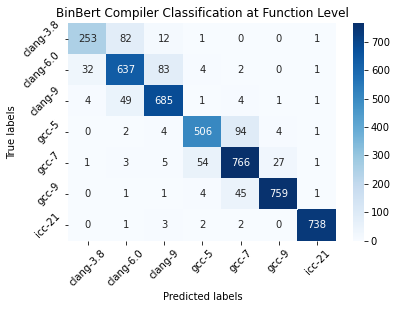

In [45]:
accuracy, predictions, references = compute_test_accuracy(test_data_loader)
compute_test_conf_matrix(predictions, references, res_filename, labels)

In [74]:
pred = np.argmax(predictions, axis=-1)
report = classification_report(references, pred)
print(report)

res_filename =  f"{res_filename}_acc_{round(accuracy,4)}.txt"
with open(res_filename, "w") as f:
    f.write(report)

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      1654
           1       0.62      0.82      0.71      1458
           2       0.54      0.22      0.32       830
           3       0.47      0.41      0.44       936

    accuracy                           0.67      4878
   macro avg       0.62      0.59      0.59      4878
weighted avg       0.66      0.67      0.65      4878

